In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

In [2]:

def load_and_split_data(filepath: str, test_size: float = 0.3, random_state: int = 0) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Carga y divide los datos en entrenamiento y prueba."""
    df = pd.read_csv(filepath)
    
    # Identificar columnas no numéricas (IDs) y la columna objetivo
    non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
    
    # Remover columnas no numéricas excepto la última (que es el target)
    cols_to_drop = [col for col in non_numeric_cols if col != df.columns[-1]]
    
    if cols_to_drop:
        X = df.drop(cols_to_drop + [df.columns[-1]], axis=1)
    else:
        X = df.iloc[:, :-1]
    
    y = df.iloc[:, -1]
    
    return train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

In [3]:
def cross_validate_model(X: pd.DataFrame, y: pd.Series, model, k: int = 3, random_state  : int = 0) -> List[float]:
    """Realiza validación cruzada y retorna las precisiones de cada pliegue."""
    kfold = KFold(n_splits=k, shuffle=False)
    accuracies = []
    
    for train_idx, val_idx in kfold.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        accuracies.append(accuracy_score(y_val_fold, y_pred))
    
    return accuracies

In [4]:

def generate_table1_results(datasets: Dict[str, str]) -> pd.DataFrame:
    """Genera la Tabla 1 con resultados de validación cruzada."""
    results = []
    
    for dataset_name, filepath in datasets.items():
        X_train, _, y_train, _ = load_and_split_data(filepath)
        
        models = {
            'one_neighbor': KNeighborsClassifier(n_neighbors=1),
            'uniform': KNeighborsClassifier(n_neighbors=10, weights='uniform'),
            'distance': KNeighborsClassifier(n_neighbors=1, weights='distance')
        }
        
        for dist_name, model in models.items():
            accuracies = cross_validate_model(X_train, y_train, model)
            
            for fold, acc in enumerate(accuracies, 1):
                results.append({
                    'Dataset': dataset_name,
                    'Distribución': dist_name,
                    'Pliegue': fold,
                    'Accuracy': f'{acc:.4f}'
                })
            
            results.append({
                'Dataset': dataset_name,
                'Distribución': dist_name,
                'Pliegue': 'Promedio',
                'Accuracy': f'{np.mean(accuracies):.4f}'
            })
    
    return pd.DataFrame(results)

In [5]:

def select_best_model(X_train: pd.DataFrame, y_train: pd.Series) -> Tuple[object, str]:
    """Selecciona el mejor modelo basado en accuracy promedio."""
    models = {
        'one_neighbor': KNeighborsClassifier(n_neighbors=1),
        'uniform': KNeighborsClassifier(n_neighbors=10, weights='uniform'),
        'distance': KNeighborsClassifier(n_neighbors=1, weights='distance')
    }
    
    best_acc, best_model, best_name = 0, None, ''
    
    for name, model in models.items():
        accuracies = cross_validate_model(X_train, y_train, model)
        avg_acc = np.mean(accuracies)
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_model = model
            best_name = name
    
    return best_model, best_name

In [6]:

def evaluate_final_model(filepath: str) -> Tuple[float, str, object, pd.Series, pd.Series]:
    """Evalúa el modelo final en el conjunto de prueba."""
    X_train, X_test, y_train, y_test = load_and_split_data(filepath)
    
    best_model, dist_name = select_best_model(X_train, y_train)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    return accuracy_score(y_test, y_pred), dist_name, best_model, y_test, y_pred

In [7]:

def display_results(datasets: Dict[str, str]) -> None:
    """Muestra todos los resultados de la práctica."""
    print("=" * 80)
    print("TABLA 1: Resultados de Validación Cruzada (Etapa de Entrenamiento)")
    print("=" * 80)
    table1 = generate_table1_results(datasets)
    print(table1.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("TABLA 2: Resultados de Pruebas Finales (Etapa de Pruebas)")
    print("=" * 80)
    
    table2_results = []
    
    for dataset_name, filepath in datasets.items():
        acc, dist, model, y_test, y_pred = evaluate_final_model(filepath)
        table2_results.append({
            'Dataset': dataset_name,
            'Distribución': dist,
            'Accuracy': f'{acc:.4f}'
        })
        
        print(f"\n{'-' * 80}")
        print(f"Dataset: {dataset_name} - Distribución: {dist}")
        print(f"{'-' * 80}")
        
        print("\nMatriz de Confusión:")
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        
        print("\nReporte de Clasificación:")
        print(classification_report(y_test, y_pred))
        
        fig, ax = plt.subplots(figsize=(8, 6))
        ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test)).plot(ax=ax, cmap='Blues')
        plt.title(f'Matriz de Confusión - {dataset_name} ({dist})')
        plt.tight_layout()
        plt.show()
    
    print("\n" + "=" * 80)
    table2 = pd.DataFrame(table2_results)
    print(table2.to_string(index=False))

TABLA 1: Resultados de Validación Cruzada (Etapa de Entrenamiento)
   Dataset Distribución  Pliegue Accuracy
  iris.csv one_neighbor        1   0.8571
  iris.csv one_neighbor        2   1.0000
  iris.csv one_neighbor        3   0.9429
  iris.csv one_neighbor Promedio   0.9333
  iris.csv      uniform        1   0.9143
  iris.csv      uniform        2   1.0000
  iris.csv      uniform        3   0.9143
  iris.csv      uniform Promedio   0.9429
  iris.csv     distance        1   0.8571
  iris.csv     distance        2   1.0000
  iris.csv     distance        3   0.9429
  iris.csv     distance Promedio   0.9333
emails.csv one_neighbor        1   0.8567
emails.csv one_neighbor        2   0.8360
emails.csv one_neighbor        3   0.8466
emails.csv one_neighbor Promedio   0.8464
emails.csv      uniform        1   0.8757
emails.csv      uniform        2   0.8476
emails.csv      uniform        3   0.8599
emails.csv      uniform Promedio   0.8610
emails.csv     distance        1   0.8567
emails.cs

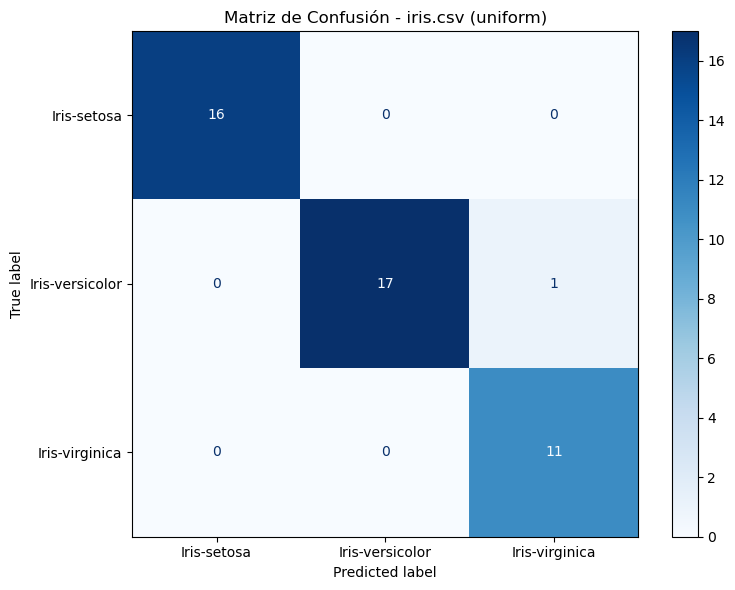


--------------------------------------------------------------------------------
Dataset: emails.csv - Distribución: uniform
--------------------------------------------------------------------------------

Matriz de Confusión:
[[995 116]
 [102 339]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1111
           1       0.75      0.77      0.76       441

    accuracy                           0.86      1552
   macro avg       0.83      0.83      0.83      1552
weighted avg       0.86      0.86      0.86      1552



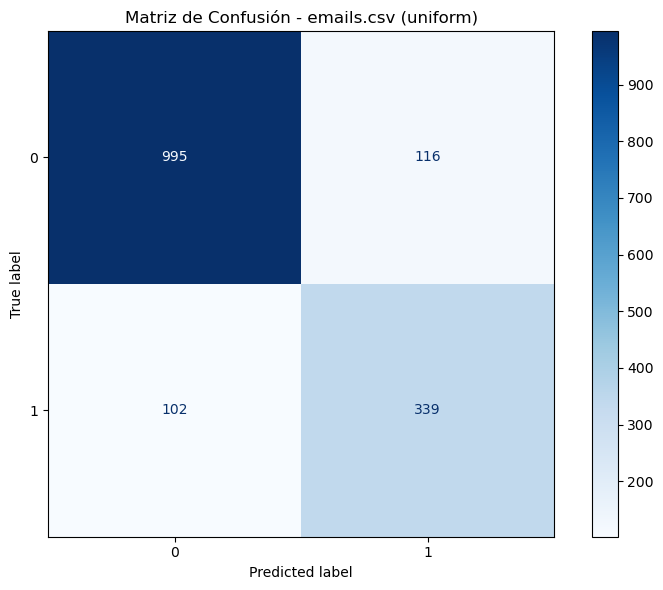


   Dataset Distribución Accuracy
  iris.csv      uniform   0.9778
emails.csv      uniform   0.8595


In [8]:
datasets = {
    'iris.csv': 'iris.csv',
    'emails.csv': 'emails.csv'
}
    
display_results(datasets)